In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [2]:
# Read all npy files
X = []
y = []
k = 0
for f in os.scandir("./coords/openpose"):
    if f.is_file() and f.name != '.DS_Store':
        x = np.load(f)
        
        # Remove empty coords
        x = [coords for coords in x if 1 in coords.shape]
        x = np.concatenate(x)
        
        # Sanity check
        X.append(x)
        y.extend([k]*x.shape[0])
        k += 1

X = np.concatenate(X)
y = np.array(y)
print("X shape: {}".format(X.shape))
print("Y shape: {}".format(y.shape))

X shape: (1540, 25, 3)
Y shape: (1540,)


In [3]:
def scale_transform_normalize(coords):
    """
    Parameters:
    coords (ndarray): array of (x,y,c) coordinates

    Returns:
    ndarray: coords scaled to 1x1 with center at (0,0)
    ndarray: confidence scores of each joint
    """
    coords, scores = coords[:,:,:-1], coords[:,:,-1]
    diff = coords.max(axis=1) - coords.min(axis=1)
    diff_max = np.max(diff, axis=0)
    mean = coords.mean(axis=1).reshape(coords.shape[0],1,coords.shape[-1])
    out = (coords - mean) / diff_max
    out /= np.linalg.norm(out)
    
    return out, scores

In [4]:
# Prepare X
X_norm, scores = scale_transform_normalize(X)
X_norm = X_norm.reshape((X_norm.shape[0], 1, -1))

# Prepare y
y_pred = []
y_truth = []
N,_,_ = X_norm.shape

# Grab every possible combination of 2 rows
for index in tqdm(combinations(np.arange(N), 2)):
    vec_1 = X_norm[index[0]]
    vec_2 = X_norm[index[1]]
    cosine_score = cosine_similarity(vec_1, vec_2)[0]
    y_pred.append(cosine_score)
    y_truth.append(int(y[index[0]] == y[index[1]]))

1185030it [03:50, 5134.87it/s]


AUC: 0.739


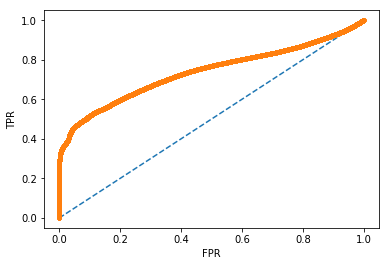

In [5]:
# Check ROC, AUC
fpr, tpr, thresholds = roc_curve(y_truth, y_pred)
auc = roc_auc_score(y_truth, y_pred)
print('AUC: %.3f' % auc)

# Plot
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()